In [1]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize

import os
from PIL import Image

import sys
sys.path.append('cloth3d')
sys.path.append('cloth3d/DataReader')
sys.path.append('cloth3d/DataReader/smpl')

from cloth3d.DataReader.read import DataReader
from cloth3d.DataReader.depth_render import Render
from cloth3d.DataReader.util import intrinsic, extrinsic

# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

N_TRAIN = 128
N_VAL = 16

n_epochs = 20
batch_size = 4

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, batch_size=16, shuffle=True, data_augmentation=False):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        # data augmentation configuration
        self.augmenter = None
        if data_augmentation:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                shear_range=0.2,
                horizontal_flip=True,
                fill_mode='reflect'
            )

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        data_list_temp = self.getdatalist(index)

        # Generate data
        X, y = self.__data_generation(data_list_temp)
        
        return X, y

    def getdatalist(self, index):
        'Get the list of data for one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_batch = [self.data_list[k] for k in indexes]

        return data_list_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, data_list):
      'Generates data containing batch_size samples'
      X_img, Y_depth = [], []
      for f in data_list:
        # Load depth image
        dpt = np.load(open(self.root + f[:5] + '/depth/'+f+'.npy', 'rb'))
        mask = dpt>0
        # Normalize depth image
        min = dpt[mask].min()
        mean = dpt[mask].mean()
        max = dpt[mask].max()
        #dpt[mask] = (dpt[mask] - min + 0.001) / 2.0
        dpt[dpt>0] -= dpt[dpt>0].mean()
        dpt[dpt<0] = 0
        Y_depth.append(dpt)

        # Read RGB image
        img = cv2.imread(self.root + f[:5] + '/image/'+f+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        img = np.array(img)
        
        # Normalize RGB image
        r_mean, g_mean, b_mean = [img[:, :, 0][mask].mean(), img[:, :, 1][mask].mean(), img[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [img[:, :, 0][mask].std(), img[:, :, 1][mask].std(), img[:, :, 2][mask].std()]
        img[:, :, 0][mask] = (img[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        img[:, :, 1][mask] = (img[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        img[:, :, 2][mask] = (img[:, :, 2][mask] - b_mean) / (b_std + 0.0001)
        
        X_img.append(img)

      # img = preprocess(img)

      # Augment the data
      if self.augmenter is not None:
          augmented_images = []
          augmented_depth = []
          for img, depth in zip(X_img, Y_depth):

              # Modified version
              augmented = self.augmenter.random_transform(np.concatenate((img, depth[..., np.newaxis]), axis=-1))
              augmented_images.append(augmented[:, :, :3])  # RGB channels
              augmented_depth.append(augmented[:, :, 3])  # Depth channel

          X_img = augmented_images
          Y_depth = augmented_depth
          return np.array(X_img), np.array(Y_depth)

      else:
          return np.array(X_img), np.array(Y_depth)


def visualize_hist(history, show=True, filename=None, title='Training history'):
    # Visualization
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()
    
    if filename is not None:
        fig.savefig(filename)


class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr):.6f}")

class TensorBoardLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir='./logs'):
        super(TensorBoardLearningRateLogger, self).__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        with self.file_writer.as_default():
            tf.summary.scalar('learning_rate', tf.keras.backend.get_value(lr), step=epoch)

2024-05-20 22:31:26.660694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 22:31:26.684101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 22:31:27.078291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


SRC: cloth3d++_subset/


# Load Data

In [2]:
# Read the data lists

subfolders = [x for x in os.listdir(SRC) if x.isdigit()]
subfolders.sort(key=int)
print(subfolders)

training_folders = subfolders[:N_TRAIN]
validation_folders = subfolders[N_TRAIN:N_TRAIN+N_VAL]
test_folders = subfolders[N_TRAIN+N_VAL:]

train_list = []
for sample in training_folders:
    try:
        train_list += os.listdir(SRC + sample + '/image')
    except:
        pass
train_list = list(map(lambda filename: filename[:-4], train_list))[0::80]
to_remove = [261, 259, 188]

for x in to_remove:
    del train_list[x]

validation_list = []
for sample in validation_folders:
    try:
        validation_list += os.listdir(SRC + sample + '/image')
    except:
        pass
validation_list = list(map(lambda filename: filename[:-4], validation_list))[0::30]

test_list = []
for sample in test_folders:
    try:
        test_list += os.listdir(SRC + sample + '/image')
    except:
        pass
test_list = list(map(lambda filename: filename[:-4], test_list))[0::30]

['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00011', '00012', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00023', '00024', '00027', '00028', '00029', '00030', '00031', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00043', '00044', '00045', '00046', '00048', '00049', '00050', '00051', '00053', '00054', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00076', '00077', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00096', '00097', '00098', '00100', '00101', '00102', '00103', '00105', '00106', '00107', '00108', '00110', '00112', '00113', '00114', '00115', '00116', '00117', '00118', '00120', '00121', '00122', '00124', '00125', '00127', '00128', '00129', '00130', '00131', '00132', '00133', '00134', 

In [3]:
print(len(train_list))
print(len(validation_list))
print(len(test_list))

372
108
77


# Experiment 1: Constant Learning Rates

Number of data used to train:
372



2024-05-20 22:31:29.095807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 22:31:29.113273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 22:31:29.113415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Learning rate: 1e-05
Epoch 1/20


2024-05-20 22:31:32.523358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-20 22:31:32.603956: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-20 22:31:32.603976: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-05-20 22:31:32.604020: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-20 22:31:34.602335: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6177df6c8110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-20 22:31:34.602362: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecuto

93/93 [==============================] - 39s 297ms/step - loss: 0.1307 - mae: 0.3264 - val_loss: 0.1994 - val_mae: 0.4226
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0721 - mae: 0.2279 - val_loss: 0.1391 - val_mae: 0.3461
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0517 - mae: 0.1909 - val_loss: 0.0881 - val_mae: 0.2687
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0419 - mae: 0.1719 - val_loss: 0.0578 - val_mae: 0.2118
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0355 - mae: 0.1596 - val_loss: 0.0445 - val_mae: 0.1783
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0311 - mae: 0.1498 - val_loss: 0.0332 - val_mae: 0.1543
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0275 - mae: 0.1425 - val_loss: 0.0286 - val_mae: 0.1412
Epoch 8/20
93/93 [==============================] - 27s 294ms/step - loss: 0.024

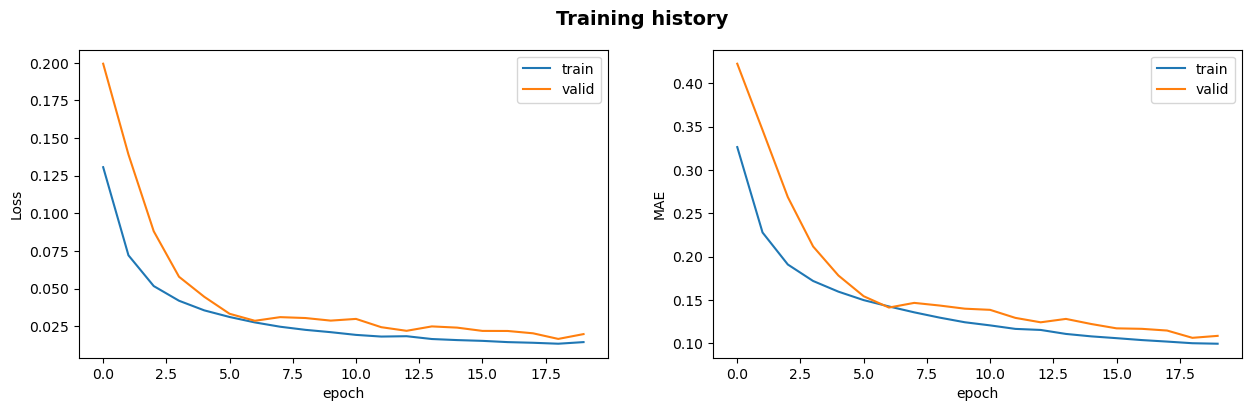

Best validation loss: 0.016535839065909386 at epoch 18
Learning rate: 0.0001
Epoch 1/20
93/93 [==============================] - 33s 297ms/step - loss: 0.0707 - mae: 0.2090 - val_loss: 0.1357 - val_mae: 0.3400
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0244 - mae: 0.1304 - val_loss: 0.0636 - val_mae: 0.2320
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0181 - mae: 0.1126 - val_loss: 0.3627 - val_mae: 0.4952
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0177 - mae: 0.1043 - val_loss: 0.0273 - val_mae: 0.1533
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0141 - mae: 0.0927 - val_loss: 0.0317 - val_mae: 0.1513
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0113 - mae: 0.0846 - val_loss: 0.0135 - val_mae: 0.0851
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0104 - mae: 0.0783 - val_loss: 0.0129 - val_mae:

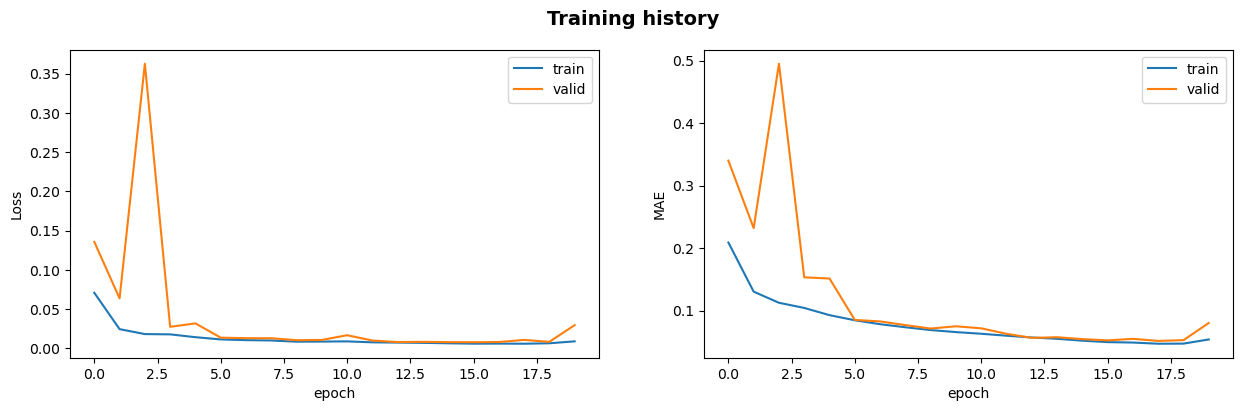

Best validation loss: 0.0077479127794504166 at epoch 15
Learning rate: 0.001
Epoch 1/20
93/93 [==============================] - 33s 297ms/step - loss: 0.0531 - mae: 0.1759 - val_loss: 0.4950 - val_mae: 0.6129
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0143 - mae: 0.0705 - val_loss: 0.1045 - val_mae: 0.3098
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0121 - mae: 0.0620 - val_loss: 0.0586 - val_mae: 0.2280
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0101 - mae: 0.0541 - val_loss: 0.0490 - val_mae: 0.2098
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0084 - mae: 0.0472 - val_loss: 0.0464 - val_mae: 0.2016
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0078 - mae: 0.0432 - val_loss: 0.0136 - val_mae: 0.0685
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0072 - mae: 0.0406 - val_loss: 0.0106 - val_mae:

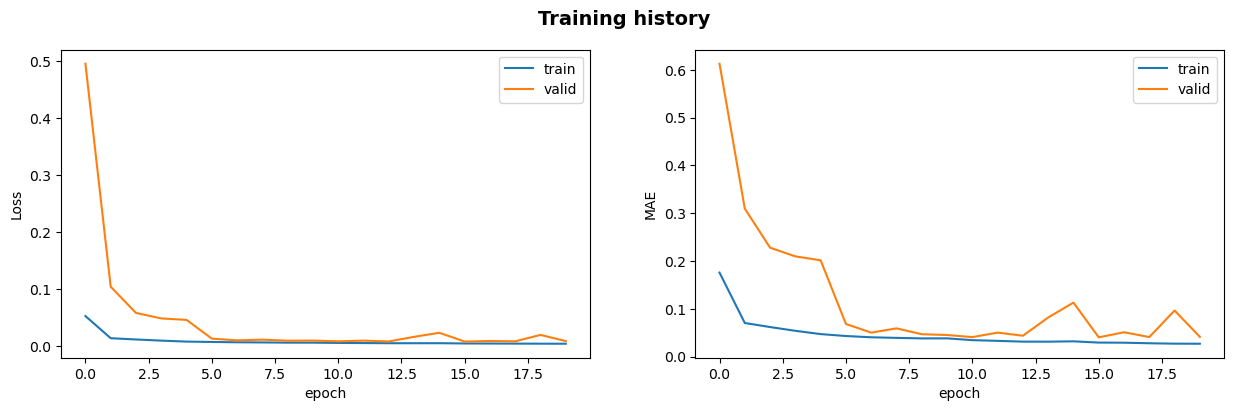

Best validation loss: 0.008457614108920097 at epoch 15
Learning rate: 0.01
Epoch 1/20
93/93 [==============================] - 33s 296ms/step - loss: 0.0263 - mae: 0.0934 - val_loss: 0.5787 - val_mae: 0.6966
Epoch 2/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0099 - mae: 0.0493 - val_loss: 0.1556 - val_mae: 0.3701
Epoch 3/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0088 - mae: 0.0438 - val_loss: 0.1559 - val_mae: 0.3705
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0080 - mae: 0.0403 - val_loss: 0.0818 - val_mae: 0.2645
Epoch 5/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0074 - mae: 0.0376 - val_loss: 0.1181 - val_mae: 0.3186
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0068 - mae: 0.0345 - val_loss: 0.0293 - val_mae: 0.1425
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0064 - mae: 0.0321 - val_loss: 0.0553 - val_mae: 0

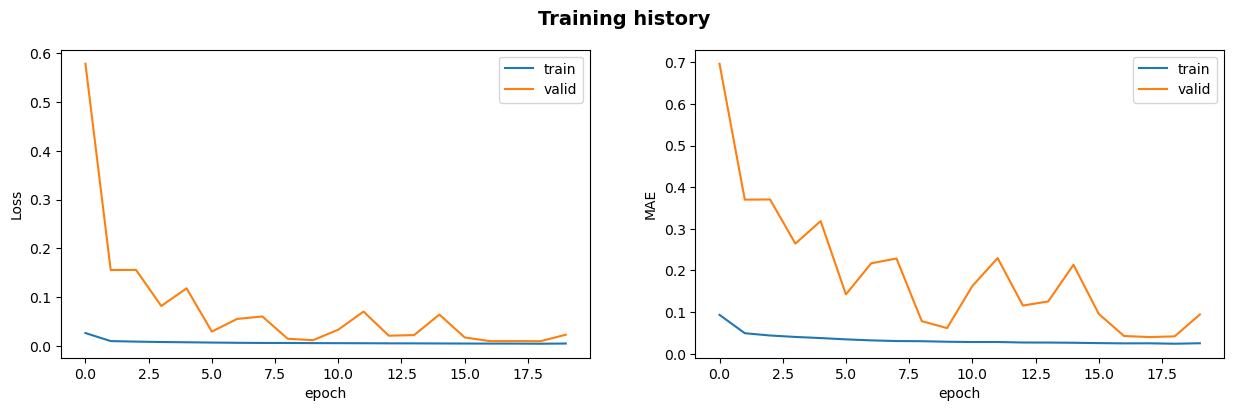

Best validation loss: 0.00964335910975933 at epoch 18


In [4]:
# Training
# hyperparameters
checkpoint = './best_model.h5'
shuffle = True
verbose = 1

# creating data generators to load the data
train_dg = DataGenerator(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_dg = DataGenerator(validation_list, SRC, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_dg.data_list))
print('')


d_lr = {}
for lr in [1e-5, 1e-4, 1e-3, 1e-2]:

    # Create model
    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                        stack_num_down=2, stack_num_up=1,
                        activation='GELU', output_activation='Sigmoid', 
                        batch_norm=True, pool='max', unpool=False, name='unet')

    print('Learning rate:', lr)

    experiment_name = 'lr_'+str(lr)

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(log_dir=os.path.join('./logs', experiment_name))
    
    # defining the optimizer
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, 
                        callbacks=[tensorboard_callback, tensorboard_lr_logger])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history_lr_'+str(lr)+'.png')
    visualize_hist(history, show=True, filename=filename)
    
    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 2: Warmup Learning Rates

In [7]:
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)
        
        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)
        
        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate
        
        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }


Number of data used to train:
372

Learning rate: 1e-05
Epoch 1/20
93/93 [==============================] - 33s 297ms/step - loss: 0.0768 - mae: 0.2094 - val_loss: 0.9104 - val_mae: 0.9417
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0156 - mae: 0.0677 - val_loss: 0.9104 - val_mae: 0.9417
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0121 - mae: 0.0592 - val_loss: 0.1687 - val_mae: 0.3837
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0084 - mae: 0.0419 - val_loss: 0.1405 - val_mae: 0.3578
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0071 - mae: 0.0368 - val_loss: 0.0665 - val_mae: 0.2461
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0066 - mae: 0.0341 - val_loss: 0.0566 - val_mae: 0.2246
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0060 - mae: 0.0319 - val_loss: 0.0396 - val_mae: 0.1820
Epoch 8/20
93

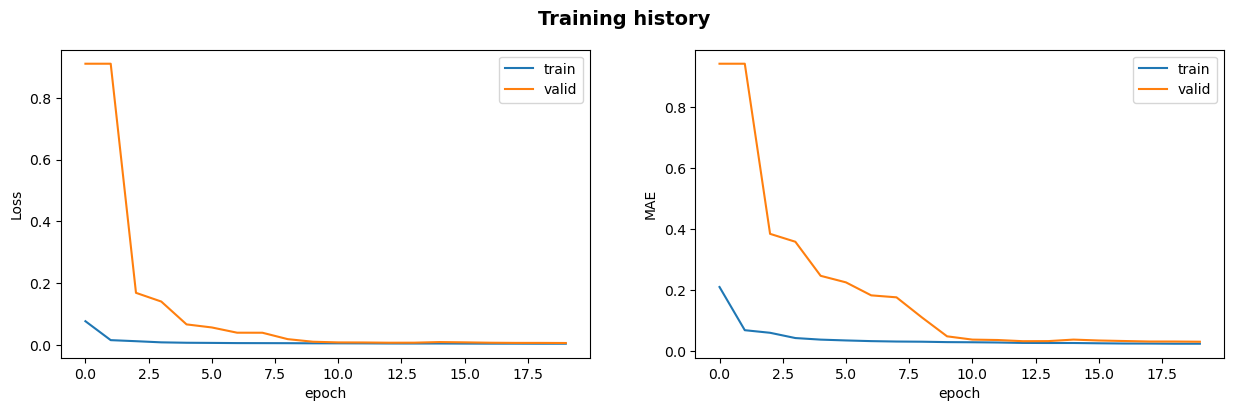

Best validation loss: 0.006323505192995071 at epoch 19
Learning rate: 1e-05
Epoch 1/20
93/93 [==============================] - 34s 298ms/step - loss: 0.0479 - mae: 0.1615 - val_loss: 0.9081 - val_mae: 0.9403
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0140 - mae: 0.0778 - val_loss: 0.0272 - val_mae: 0.0606
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0080 - mae: 0.0463 - val_loss: 0.0395 - val_mae: 0.1849
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0068 - mae: 0.0387 - val_loss: 0.0755 - val_mae: 0.2639
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0063 - mae: 0.0354 - val_loss: 0.0485 - val_mae: 0.2038
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0063 - mae: 0.0339 - val_loss: 0.0484 - val_mae: 0.2091
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0059 - mae: 0.0317 - val_loss: 0.0261 - val_mae: 

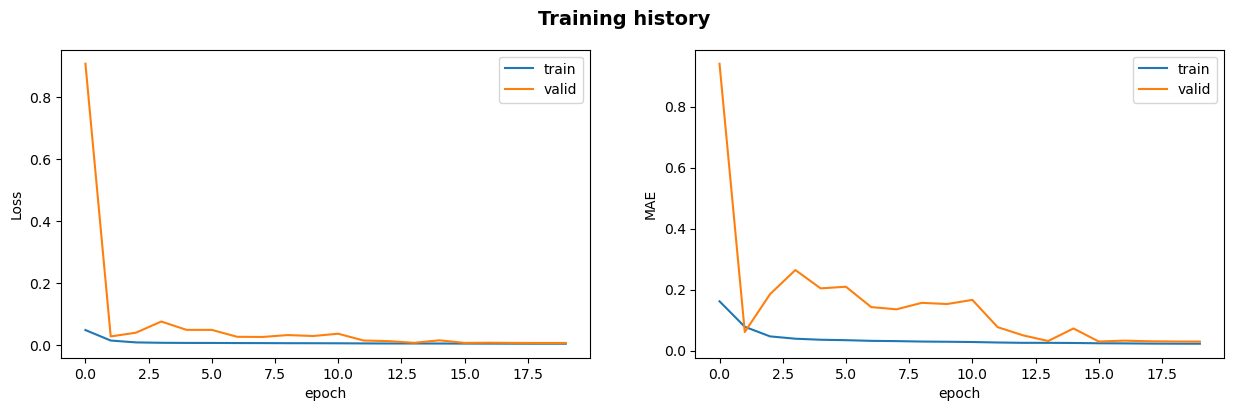

Best validation loss: 0.006185141857713461 at epoch 19
Learning rate: 1e-05
Epoch 1/20
93/93 [==============================] - 34s 298ms/step - loss: 0.0437 - mae: 0.1536 - val_loss: 0.7149 - val_mae: 0.8124
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0115 - mae: 0.0695 - val_loss: 0.0703 - val_mae: 0.2015
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0081 - mae: 0.0505 - val_loss: 0.1566 - val_mae: 0.3769
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0064 - mae: 0.0387 - val_loss: 0.1925 - val_mae: 0.3958
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0067 - mae: 0.0373 - val_loss: 0.0318 - val_mae: 0.1540
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0060 - mae: 0.0336 - val_loss: 0.0898 - val_mae: 0.2824
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0058 - mae: 0.0319 - val_loss: 0.0384 - val_mae: 

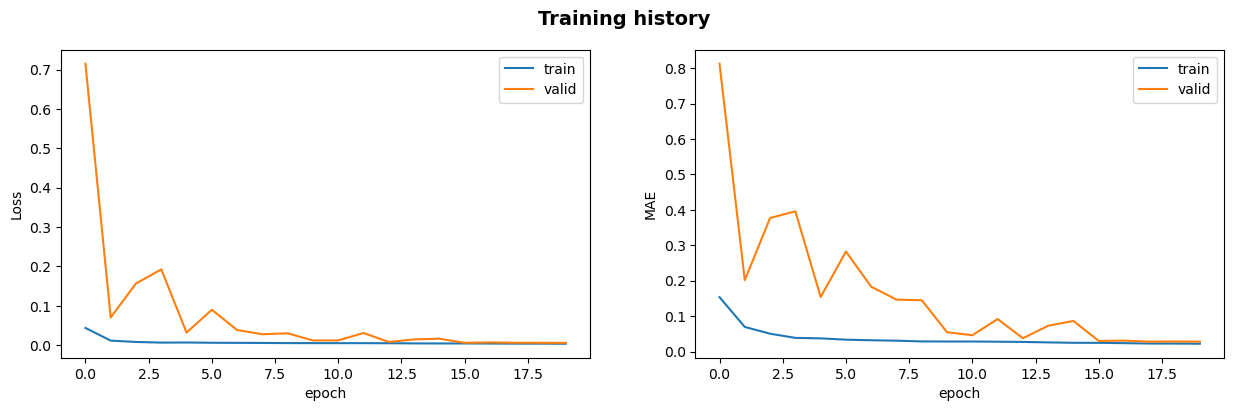

Best validation loss: 0.00582941435277462 at epoch 15


In [11]:
import tensorflow as tf
import numpy as np


# Parameters
initial_learning_rate = 1e-5
target_learning_rate = 1e-2
total_steps = len(train_list) // batch_size * n_epochs
verbose = 1
shuffle = True
checkpoint = './best_model.h5'

# creating data generators to load the data
train_dg = DataGenerator(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_dg = DataGenerator(validation_list, SRC, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_dg.data_list))
print('')




for wu_ratio in [0.1, 0.2, 0.3, 0.4]:

    warmup_steps = int(wu_ratio * total_steps)

    experiment_name = f'lr_decay_{initial_learning_rate}_{target_learning_rate}_wu_ratio_{wu_ratio}'

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join('./logs', experiment_name))

    # Create the learning rate schedule
    lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                            stack_num_down=2, stack_num_up=1,
                            activation='GELU', output_activation='Sigmoid', 
                            batch_norm=True, pool='max', unpool=False, name='unet')

    print('Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, 
                        callbacks=[tensorboard_callback, tensorboard_lr_logger])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 3: Learning Rate Schedules (No Warmup)

Number of data used to train:
372

Initial Learning rate: 1e-06
Epoch 1/20
93/93 [==============================] - 33s 296ms/step - loss: 0.2262 - mae: 0.4553 - val_loss: 0.2232 - val_mae: 0.4539
Epoch 2/20
93/93 [==============================] - 27s 293ms/step - loss: 0.2057 - mae: 0.4337 - val_loss: 0.2132 - val_mae: 0.4435
Epoch 3/20
93/93 [==============================] - 27s 293ms/step - loss: 0.1894 - mae: 0.4136 - val_loss: 0.2043 - val_mae: 0.4319
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.1746 - mae: 0.3934 - val_loss: 0.1986 - val_mae: 0.4203
Epoch 5/20
93/93 [==============================] - 27s 293ms/step - loss: 0.1607 - mae: 0.3731 - val_loss: 0.1848 - val_mae: 0.3978
Epoch 6/20
93/93 [==============================] - 27s 293ms/step - loss: 0.1475 - mae: 0.3539 - val_loss: 0.1694 - val_mae: 0.3742
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.1371 - mae: 0.3386 - val_loss: 0.1564 - val_mae: 0.3551
Epoch

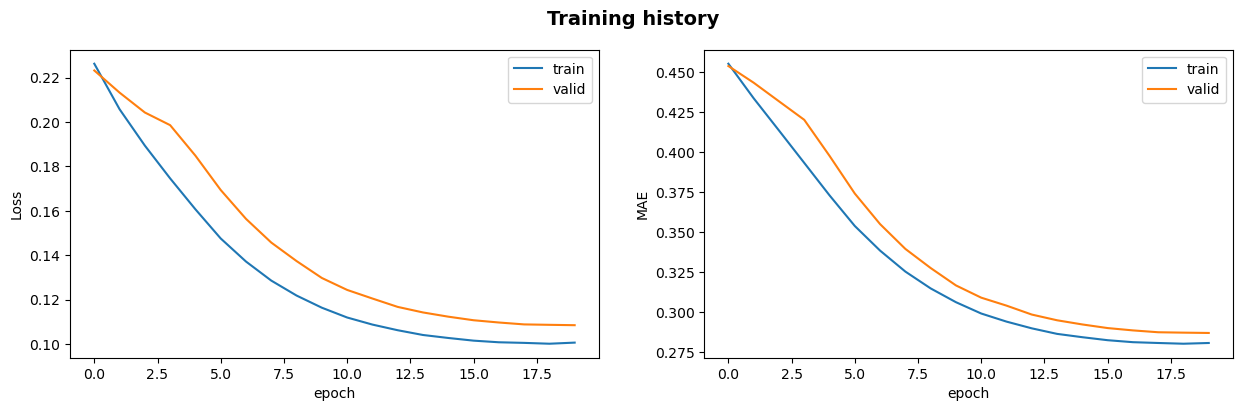

Best validation loss: 0.10848765820264816 at epoch 19
Initial Learning rate: 1e-05
Epoch 1/20
93/93 [==============================] - 33s 297ms/step - loss: 0.1253 - mae: 0.3300 - val_loss: 0.1704 - val_mae: 0.3962
Epoch 2/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0667 - mae: 0.2343 - val_loss: 0.1193 - val_mae: 0.3271
Epoch 3/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0492 - mae: 0.1982 - val_loss: 0.0907 - val_mae: 0.2798
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0414 - mae: 0.1803 - val_loss: 0.0614 - val_mae: 0.2251
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0365 - mae: 0.1689 - val_loss: 0.0448 - val_mae: 0.1869
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0330 - mae: 0.1599 - val_loss: 0.0399 - val_mae: 0.1747
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0301 - mae: 0.1531 - val_loss: 0.0346 - va

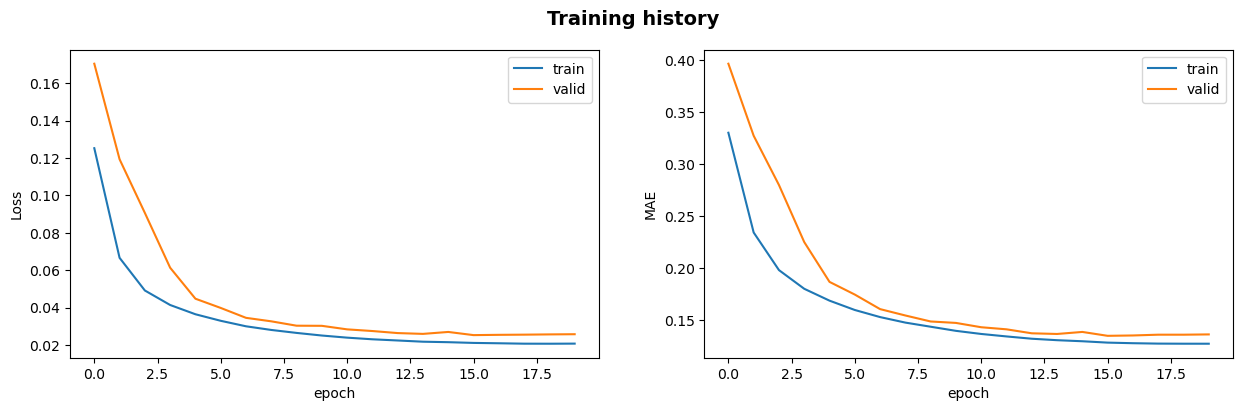

Best validation loss: 0.025343554094433784 at epoch 15
Initial Learning rate: 0.0001
Epoch 1/20
93/93 [==============================] - 33s 296ms/step - loss: 0.0767 - mae: 0.2207 - val_loss: 0.1212 - val_mae: 0.3129
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0258 - mae: 0.1369 - val_loss: 0.0428 - val_mae: 0.1879
Epoch 3/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0232 - mae: 0.1213 - val_loss: 0.0730 - val_mae: 0.2553
Epoch 4/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0174 - mae: 0.1084 - val_loss: 0.0448 - val_mae: 0.1999
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0137 - mae: 0.0988 - val_loss: 0.0574 - val_mae: 0.2252
Epoch 6/20
93/93 [==============================] - 27s 293ms/step - loss: 0.0138 - mae: 0.0921 - val_loss: 0.0407 - val_mae: 0.1734
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0124 - mae: 0.0867 - val_loss: 0.0420 - 

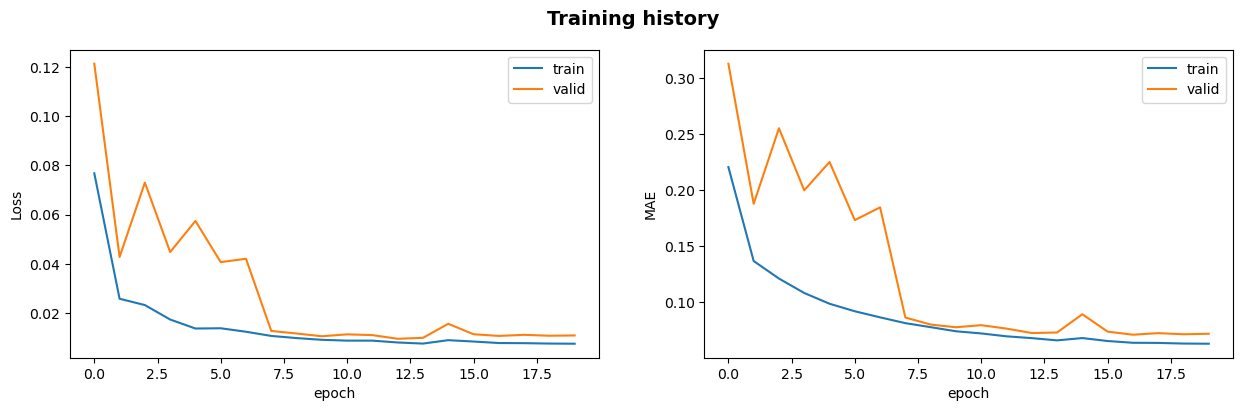

Best validation loss: 0.009543920867145061 at epoch 12
Initial Learning rate: 0.001
Epoch 1/20
93/93 [==============================] - 33s 297ms/step - loss: 0.0390 - mae: 0.1403 - val_loss: 0.9050 - val_mae: 0.9374
Epoch 2/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0147 - mae: 0.0736 - val_loss: 0.5475 - val_mae: 0.6632
Epoch 3/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0096 - mae: 0.0568 - val_loss: 0.0595 - val_mae: 0.2337
Epoch 4/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0075 - mae: 0.0500 - val_loss: 0.0319 - val_mae: 0.1502
Epoch 5/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0069 - mae: 0.0434 - val_loss: 0.0277 - val_mae: 0.1210
Epoch 6/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0064 - mae: 0.0402 - val_loss: 0.0106 - val_mae: 0.0536
Epoch 7/20
93/93 [==============================] - 27s 294ms/step - loss: 0.0060 - mae: 0.0376 - val_loss: 0.0105 - v

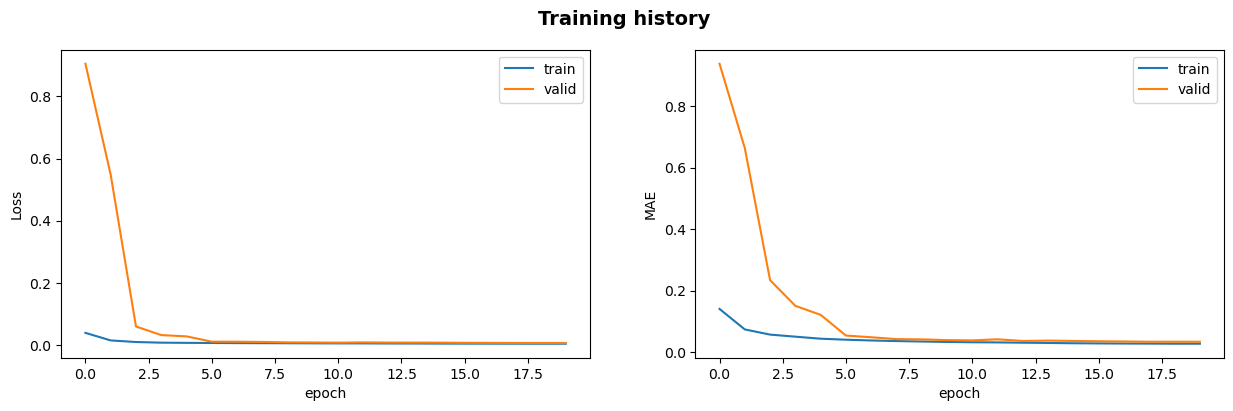

Best validation loss: 0.006396263837814331 at epoch 19


In [9]:
import tensorflow as tf
import numpy as np


# Parameters
target_learning_rate = 1e-3

total_steps = len(train_list) // batch_size * n_epochs
verbose = 1
shuffle = True
checkpoint = './best_model.h5'

# creating data generators to load the data
train_dg = DataGenerator(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_dg = DataGenerator(validation_list, SRC, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_dg.data_list))
print('')




for initial_lr in [1e-6, 1e-5, 1e-4, 1e-3]:

    initial_learning_rate = initial_lr

    experiment_name = f'lr_decay_{initial_learning_rate}'

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join('./logs', experiment_name))

    lr_schedule = keras.optimizers.schedules.CosineDecay(
                    initial_learning_rate,
                    total_steps,
                    alpha=1e-3,
                    name="CosineDecay",
                )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                            stack_num_down=2, stack_num_up=1,
                            activation='GELU', output_activation='Sigmoid', 
                            batch_norm=True, pool='max', unpool=False, name='unet')

    print('Initial Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, callbacks=[tensorboard_callback, tensorboard_lr_logger])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)